In [ ]:
!apt install libspatialindex-dev ## specjalna biblioteka do analiz przestrzennych w linux
!pip install geopandas ## biblioteka geopandas w pythonie
!pip install folium mapclassify 

#nowe pakiety inslalujemy

!pip install -U pysal urbanaccess pandana libpysal esda



Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8] ## wielkość wykresu
import folium ## folium.Map
import libpysal as ps ## wagi oraz moran
import esda ## statystyka morana
import mapclassify
from splot.esda import lisa_cluster ## wykres kartogram ze skupiskami
from splot.esda import moran_scatterplot ## wykres rozrzutu ze statysyką morana

In [ ]:
pow_df = gpd.read_file(filename="powiaty.shp", encoding = "utf-8")
pow_df = pow_df[["SP_ID","jpt_kod_je", "jpt_nazwa_","geometry"]]
pow_df.head(n = 2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37..."
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37..."


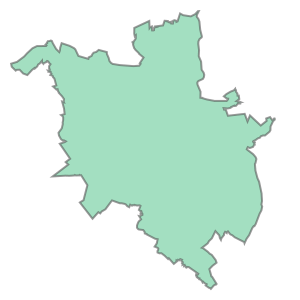

In [ ]:
pow_df.query("jpt_nazwa_ == 'powiat Poznań'").geometry[346]

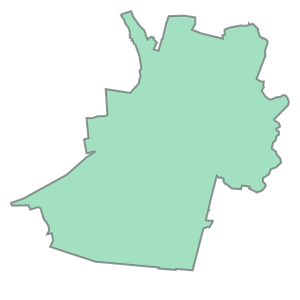

In [ ]:
pow_df.geometry[1]

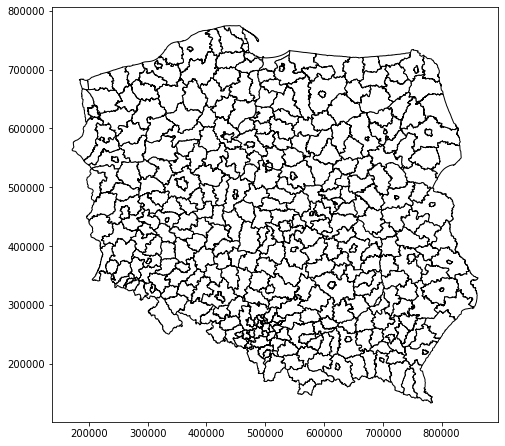

In [ ]:
pow_df.plot(color = "white", edgecolor = "black")

Dodaję informacje o przynależności danego powiatu do województwa, a następnie rysuję mapę województwa wielkopolskiego (30)

In [ ]:
pow_df["kod_woj"]= pow_df.jpt_kod_je.str.slice(stop = 2)
pow_df.head(n=2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37...",02
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37...",02


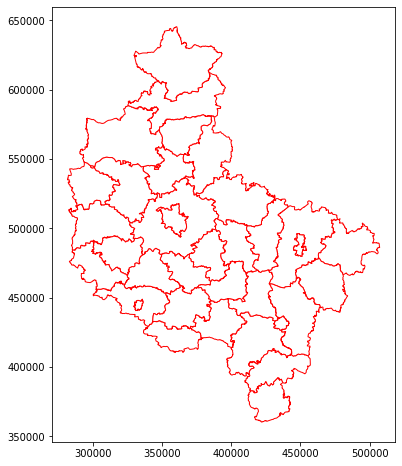

In [ ]:
pow_df.query("kod_woj == '30'").plot(color = "white", edgecolor = "red")

Interaktywana mapa

In [ ]:
 ## pow_df.query("kod_woj == '30'").explore()

Mapa poznania

In [ ]:
pzn = gpd.read_file(filename= 'Poznan.shp', encoding = 'utf-8')
pzn.head(n=3)

,ID,dzielnica,latdeg,longdeg,geometry
0,1,DASZEWICE,52.313859,16.952755,"POLYGON ((16.953 52.314, 16.953 52.314, 16.953..."
1,2,GŁUSZYNA II,52.340461,16.966497,"POLYGON ((16.966 52.340, 16.969 52.340, 16.969..."
2,3,ŁAWICA II,52.414490,16.799036,"POLYGON ((16.799 52.414, 16.799 52.415, 16.799..."


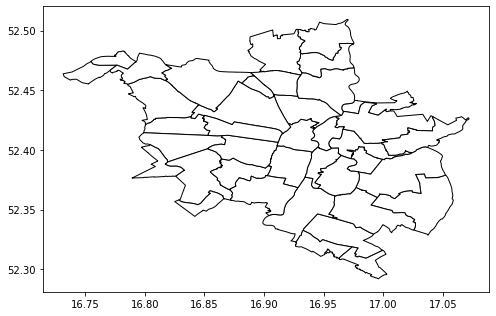

In [ ]:
pzn.plot(color = "white",edgecolor = 'black')

Wczytujemy dane z pliku exela

In [ ]:
wynag = pd.read_excel(io= 'powiaty_wynag.xlsx', sheet_name=1)
wynag = wynag[["Kod", "Wartosc"]]
wynag['kod'] = wynag.Kod.astype(str).str.zfill(7)
wynag["kod"] = wynag.kod.str.slice(start = 0, stop = 4)
wynag.head(n = 2)

,Kod,Wartosc,kod
0,201000,4214.66,0201
1,202000,4024.94,0202


In [ ]:
pow_df_dane = pd.merge(left= pow_df,
                       right = wynag[["kod", "Wartosc"]],
                       how = "left",
                       left_on = "jpt_kod_je",
                       right_on = 'kod')
pow_df_dane.head(2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj,kod,Wartosc
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37...",02,0226,4362.98
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37...",02,0262,4259.37


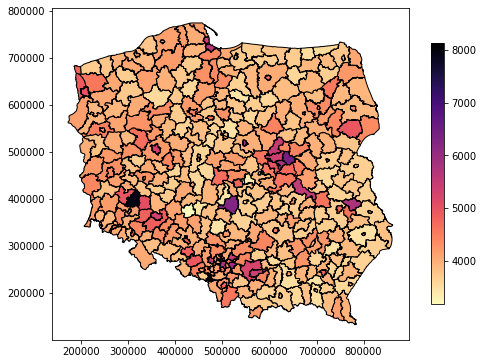

In [ ]:
pow_df_dane.plot(column = "Wartosc",cmap = 'magma_r', legend = 'True', edgecolor = 'black',
                 legend_kwds = {'shrink': 0.6}) 
## jak odwrócić kolory to magma_r

# Analizy przestrzenne 

## Wyznaczanie wag przestrzennych

In [ ]:
## dostajemy macierz 0-1
W = ps.weights.Queen.from_dataframe(pow_df_dane)
## Dostajemy się do wyznaczonej macierzy 
W.full()[0] ## wyświetlamy całą macierz


/usr/local/lib/python3.7/dist-packages/libpysal/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
/usr/local/lib/python3.7/dist-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
W.full()[0][0,:]## wyświetlamy sąsiadów pierwszego obiektu ( powiat złotoryjski)

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Aby wystandaryzować macierz wierrzowo musimy napisać następujący kod

In [ ]:
W.transform = "r" ## standaryzacja wierszami
W.full()[0][:5,:5] ## wyświetlamy od zerowego do piątego wiersza i piątej kolumny

array([[0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])

In [ ]:

## wyświetlamy sąsiadów pierwszego obiektu ( powiat złotoryjski)
W.full()[0][0,:]


array([0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

Wyznaczamy statystykę Morana I z wykorzystaniem moduły 'esda'

In [ ]:
stat_moran = esda.moran.Moran(pow_df_dane.Wartosc, W)
stat_moran.I ## wartość statystyki morana


0.23194481829022168

Interpretacja wyniku jest następująca : Statystyka MOrana I jest większa od zera i wynosi 0.23 co oznacza, że autokorelacja przestrzenna wynagrodzeń jest dodatnia. Oznacza to, że powiaty o podobnej sytuacji grupują się

In [ ]:
stat_moran.p_norm ## p-value

6.1948224328034485e-12

In [ ]:
stat_moran.seI_norm ## błąd standardowy

0.03412074183220515

Wyznaczamy statystykę MOrana I samodzielnie korzystając z następującego wzoru

In [ ]:
## róznica między wartościami obserwowanymi a średnią 
z = pow_df_dane.Wartosc - np.mean(pow_df_dane.Wartosc)
## macierz standaryzowana wierszami
W_star = W.full()[0]
## wyznaczanie zgodnie z powyższym wzorem
I_recznie = (np.transpose(z) @ W_star @ z) / (np.transpose(z) @ z)
I_recznie

0.23194481829022168

## lokalne statystyki Morana

In [ ]:
np.random.seed(1)
lokalny_moran = esda.moran.Moran_Local(pow_df_dane.Wartosc, W)
lokalny_moran

+ 'Is' -- lokalne miary morana(dla każdej jednostki)
+ //

In [ ]:
np.mean(lokalny_moran.Is), np.std(lokalny_moran.Is)
## autokorelacja przestrzenna może zaniżać odchylenia standardowe

(0.23133443718945804, 0.7269806009398164)

In [ ]:
np.sum(lokalny_moran.p_z_sim < 0.05)
## niestandaryzowane statystyki dla p_sim
## czy w danym powiecie jest istotna zależność statystyczna

59

In [ ]:
pow_df_dane.sort_values(by = 'moran2', ascending= True)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj,kod,Wartosc,moran,moran2
63,63,1001,powiat bełchatowski,"POLYGON ((489945.770 380441.322, 492229.268 38...",10,1001,6259.40,-2.541727,-2.541727
86,86,0610,powiat łęczyński,"POLYGON ((754987.929 395734.203, 755092.845 39...",06,0610,5772.29,-1.590663,-1.590663
271,271,2415,powiat wodzisławski,"POLYGON ((445512.207 243158.664, 445547.467 24...",24,2415,3725.84,-1.489296,-1.489296
276,276,2467,powiat Jastrzębie-Zdrój,"POLYGON ((465163.252 230038.515, 465227.497 23...",24,2467,8121.08,-1.280717,-1.280717
165,165,1462,powiat Płock,"POLYGON ((542338.336 517151.085, 542367.493 51...",14,1462,5705.32,-0.694060,-0.694060
...,...,...,...,...,...,...,...,...,...
28,28,0211,powiat lubiński,"POLYGON ((291305.112 387732.614, 291371.123 38...",02,0211,7915.01,3.336063,3.336063
163,163,1432,powiat warszawski zachodni,"POLYGON ((589499.227 491374.400, 589712.962 49...",14,1432,5375.27,4.467491,4.467491
143,143,1465,powiat Warszawa,"POLYGON ((626505.916 483271.600, 626528.812 48...",14,1465,6432.78,4.529169,4.529169
150,150,1421,powiat pruszkowski,"POLYGON ((611505.919 478928.219, 611697.703 47...",14,1421,5757.06,6.337780,6.337780


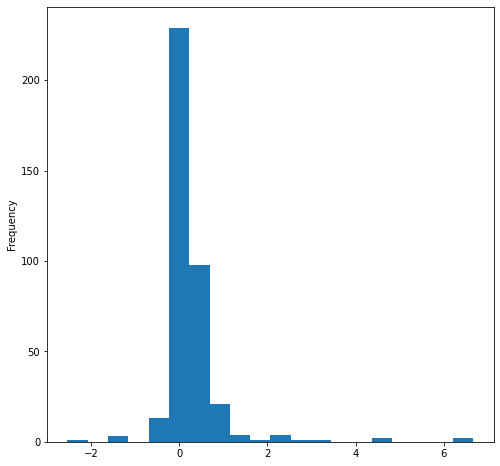

In [ ]:
pow_df_dane['moran2'] = pd.DataFrame(lokalny_moran.Is)
pow_df_dane.head(n=5)
pow_df_dane.moran2.plot.hist(bins = 20)

Wizaualizujemy skupiska powiatów na podstawie lokalnej statysyki morana.

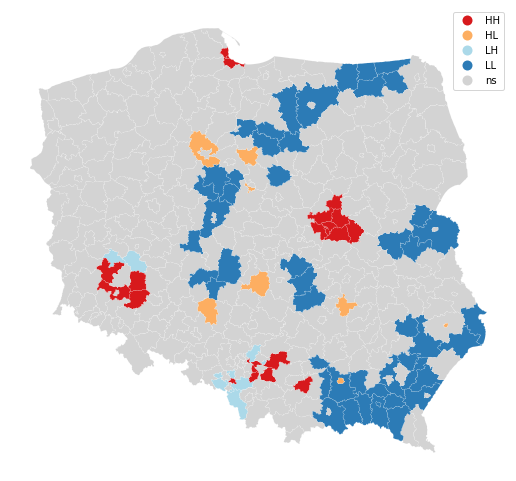

In [ ]:
lisa_cluster(lokalny_moran, pow_df_dane, p = 0.05, figsize=(9,9))
plt.show()

HH powiaty mające wysokie wynagridzenia i są oczone powiatami o wysokich wynagordzeniach
LL powiaty mające niskie wynagordzenia i otoczone niskimi wynagrodzeniami 
HL wysokie wynagrodzenia ale otoczone powiatami  o niskich wynagrodzeniach
LH niskie wynagrodzenia otoczone wysokimi wynagrodzeniami 
Są to wartości relatywne

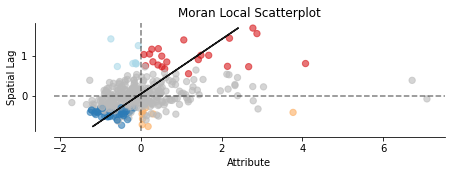

In [ ]:
fig, ax = moran_scatterplot(lokalny_moran, p = 0.05 )
plt.show() ## spiting lag sąsiedztwo, oś ox wynagordzenia :)